In [1]:
import json
import geojson
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm.auto import tqdm
from pystac import Item
from pystac_client import Client
from geojson.utils import coords
from pyproj import Transformer
from shapely import wkt
from shapely.ops import transform
from shapely.geometry import Polygon, LinearRing
from odc.stac import stac_load
from IPython.display import Image

In [2]:
def bounds_to_ring(geom):
    minx, miny, maxx, maxy = geom.bounds
    return LinearRing([
        (minx, miny),
        (maxx, miny),
        (maxx, maxy),
        (minx, maxy),
        (minx, miny)
    ])


def load_geosjon(path: str) -> dict:
    with open(path, "r") as f:
        obj = geojson.load(f)
    return obj


def get_polygon_from_geometry(geometry: dict) -> Polygon:
    return Polygon(coords(geometry['coordinates']))


# def get_polygon_from_geometry(geometry: str) -> Polygon:
#     return wkt.loads(geometry)

In [3]:
filepath = "../../geospatial/tests_01/data/archive/BR_Municipios_2020.shp"
gdf_municipios = gpd.read_file(filepath)

In [4]:
crs = "EPSG:4674"
gdf_municipios = gdf_municipios.to_crs(crs)

In [5]:
gdf_municipios['boundary'] = gdf_municipios.boundary
gdf_municipios["centroid"] = gdf_municipios.centroid
gdf_municipios["bounds"] = gdf_municipios.geometry.apply(bounds_to_ring)

/tmp/ipykernel_503883/3704606062.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_municipios["centroid"] = gdf_municipios.centroid


In [6]:
gdf_municipios.head(5)

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,boundary,centroid,bounds
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...","LINESTRING (-62.19465 -11.82746, -62.19332 -11...",POINT (-62.27466 -12.47013),"LINEARRING (-62.89408 -13.11894, -61.88651 -13..."
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736...","LINESTRING (-62.53648 -9.73222, -62.52765 -9.7...",POINT (-62.95726 -9.95189),"LINEARRING (-63.61822 -10.28828, -62.42262 -10..."
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3...","LINESTRING (-60.37119 -13.36655, -60.37134 -13...",POINT (-60.63981 -13.47488),"LINEARRING (-60.92476 -13.6937, -60.36529 -13...."
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.0008 -11.29737, -61.00103 -11.39...","LINESTRING (-61.0008 -11.29737, -61.00103 -11....",POINT (-61.32473 -11.30129),"LINEARRING (-61.7958 -11.61921, -61.00059 -11...."
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0...","LINESTRING (-61.49976 -13.00525, -61.49809 -13...",POINT (-61.26095 -13.20356),"LINEARRING (-61.90804 -13.36371, -60.71665 -13..."


In [7]:
gdf_municipios['AREA_KM2'].nsmallest(10)

2911     3.565
3273     3.612
3812    15.331
3711    17.264
3550    17.449
1525    18.609
3221    19.393
1774    19.793
3855    20.388
1637    25.704
Name: AREA_KM2, dtype: float64

In [8]:
gdf = gdf_municipios.loc[[3812, 3711, 3550, 1774, 3221], ['CD_MUN', 'geometry']].reset_index(drop=True)
gdf.head(100)

,CD_MUN,geometry
0,3548807,"POLYGON ((-46.55698 -23.61209, -46.55694 -23.6..."
1,3539806,"POLYGON ((-46.35065 -23.50767, -46.35048 -23.5..."
2,3525003,"POLYGON ((-46.91529 -23.51394, -46.91525 -23.5..."
3,2802502,"POLYGON ((-36.98399 -10.68278, -36.98237 -10.6..."
4,3303203,"POLYGON ((-43.40291 -22.8003, -43.40187 -22.80..."


In [9]:
gdf_analysis = gdf[gdf['CD_MUN'] == '3548807'].reset_index()
gdf_analysis

,index,CD_MUN,geometry
0,0,3548807,"POLYGON ((-46.55698 -23.61209, -46.55694 -23.6..."


In [10]:
geom = json.loads(gdf['geometry'].to_json())['features'][0]['geometry']

In [11]:
polygon = get_polygon_from_geometry(geom)

transformer = Transformer.from_crs("urn:ogc:def:crs:OGC:1.3:CRS84", "EPSG:4326", always_xy=True)
polygon = transform(transformer.transform, polygon)

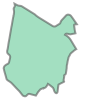

In [12]:
polygon

## Stac

In [13]:
CATALOG = "https://earth-search.aws.element84.com/v1/"
client = Client.open(CATALOG)

In [14]:
start_date = datetime(2025, 8, 10, 13, 20, 14).strftime("%Y-%m-%dT%H:%M:%S")
end_date = datetime(2025, 8, 24, 12, 30, 10).strftime("%Y-%m-%dT%H:%M:%S")

# start_date = datetime(2025, 3, 10).strftime("%Y-%m-%d")
# end_date = datetime(2025, 3, 30).strftime("%Y-%m-%d")

In [15]:

search = client.search(
    collections=["sentinel-2-l2a"],
    datetime=f"{start_date}/{end_date}",
    bbox=polygon.bounds,
    sortby=[{"field": "properties.datetime", "direction": "asc"}],
)

items = list(search.items())
print(f"Found: {len(items):d} datasets")

Found: 3 datasets


In [16]:
type(items[0])

pystac.item.Item

In [17]:
print(items[0].properties['datetime']) # usar esse pq e o que aparece no Dataset
print(items[0].properties['s2:generation_time'])
print(items[0].properties['created']) # usar esse (nao mais)
print(items[0].properties['updated'])

2025-08-13T13:18:59.003000Z
2025-08-13T15:00:43.000000Z
2025-08-13T16:27:15.597Z
2025-08-13T16:27:15.597Z


In [18]:
# print(items[0].properties['datetime'])
# print(items[0].properties['s2:generation_time'])
# print(items[0].properties['created'])
# print(items[0].properties['updated'])

In [19]:
datetime.strptime(items[0].properties['updated'], "%Y-%m-%dT%H:%M:%S.%fZ")

datetime.datetime(2025, 8, 13, 16, 27, 15, 597000)

In [20]:
# 2025-08-13 13:18:59.003

In [21]:
collections = search.item_collection()
collections

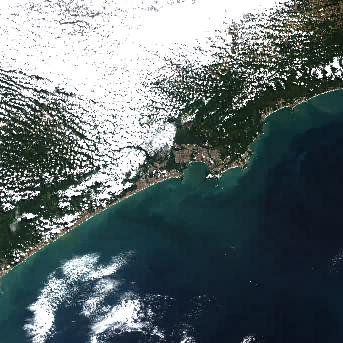

In [22]:
Image(collections[1].assets['thumbnail'].href)

## Load

In [23]:
constants = ["red", "green", "blue", "nir", "nir08", "rededge1", "rededge2", "rededge3", "swir16", "swir22"]
categorical = ["scl"]

dataset = stac_load(
    items,
    bands=(constants + categorical),
    crs="utm",
    resolution=10,
    groupby="solar_day",
    bbox=polygon.bounds,
    # dtype="uint16", # nao especificando esta trazendo scl como uint8. Isso e bom
    nodata=0,
    progress=tqdm,
    chunks={"x": 2048, "y": 2048, "time": 1},  # <-- use Dask
    resampling={**{n: "bilinear" for n in constants}, **{n: "nearest" for n in categorical}},
)

In [24]:
dataset

<xarray.Dataset> Size: 15MB
Dimensions:      (y: 570, x: 418, time: 3)
Coordinates:
  * y            (y) float64 5kB 7.389e+06 7.389e+06 ... 7.384e+06 7.384e+06
  * x            (x) float64 3kB 3.383e+05 3.383e+05 ... 3.424e+05 3.425e+05
    spatial_ref  int32 4B 32723
  * time         (time) datetime64[ns] 24B 2025-08-13T13:18:59.003000 ... 202...
Data variables:
    red          (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    green        (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    blue         (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    nir          (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    nir08        (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    rededge1     (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    rededge2     (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    rededge3     (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    swir16       (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    swir22       (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    scl          (time, y, x) uint8 715kB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>

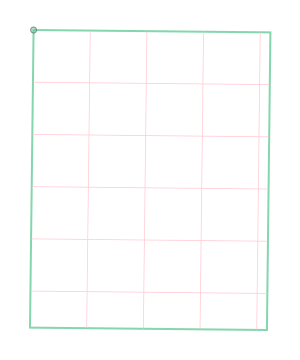

In [25]:
dataset.odc.geobox

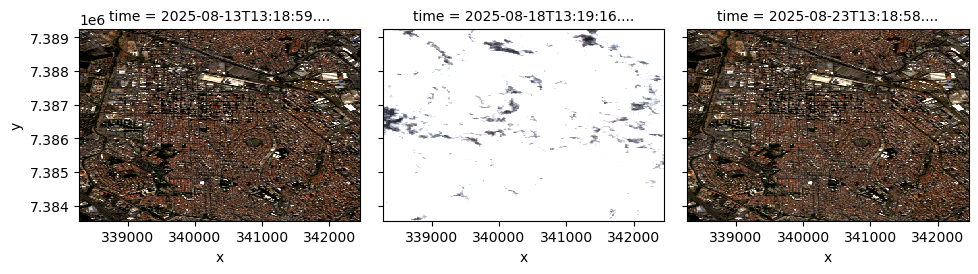

In [ ]:
# vis = dataset.odc.to_rgba(bands=("red", "green", "blue"), vmin=0, vmax=3400)
# vis.plot.imshow(col='time', rgb='band', col_wrap=5, robust=True)
# plt.show()

In [26]:
spatial_dims = [d for d in dataset['scl'].dims if d != 'time']
spatial_dims

['y', 'x']

In [29]:
dataset.sizes['y']

570

In [27]:
n_pixels_por_t = 1
for d in spatial_dims:
    n_pixels_por_t *= dataset.sizes[d]   # usa metadados, sem ler dados

n_pixels_por_t

238260

In [28]:
# ou de forma direta:
n_pixels_por_t = dataset['red'].sizes['y'] * dataset['red'].sizes['x']
n_pixels_por_t

238260

In [33]:
dataset['ndvi'] = (dataset.nir - dataset.red) / (dataset.nir + dataset.red).astype('float32')

In [34]:
dataset

<xarray.Dataset> Size: 18MB
Dimensions:      (y: 570, x: 418, time: 3)
Coordinates:
  * y            (y) float64 5kB 7.389e+06 7.389e+06 ... 7.384e+06 7.384e+06
  * x            (x) float64 3kB 3.383e+05 3.383e+05 ... 3.424e+05 3.425e+05
    spatial_ref  int32 4B 32723
  * time         (time) datetime64[ns] 24B 2025-08-13T13:18:59.003000 ... 202...
Data variables:
    red          (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    green        (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    blue         (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    nir          (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    nir08        (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    rededge1     (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    rededge2     (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    rededge3     (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    swir16       (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    swir22       (time, y, x) uint16 1MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    scl          (time, y, x) uint8 715kB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>
    ndvi         (time, y, x) float32 3MB dask.array<chunksize=(1, 570, 418), meta=np.ndarray>

In [35]:
pixels = dataset.isel(time=0)['scl'].count(dim=('y','x')).values.item()
pixels

238260

In [36]:
dataset['scl']

<xarray.DataArray 'scl' (time: 3, y: 570, x: 418)> Size: 715kB
dask.array<scl, shape=(3, 570, 418), dtype=uint8, chunksize=(1, 570, 418), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5kB 7.389e+06 7.389e+06 ... 7.384e+06 7.384e+06
  * x            (x) float64 3kB 3.383e+05 3.383e+05 ... 3.424e+05 3.425e+05
    spatial_ref  int32 4B 32723
  * time         (time) datetime64[ns] 24B 2025-08-13T13:18:59.003000 ... 202...
Attributes:
    nodata:   0

In [37]:
scl = dataset['scl']

# max_cat = int(scl.max().compute())
# n_categories = max_cat + 1
n_categories = 12

In [38]:
scl.isel(time=0).count(dim=('y','x')).values.item()

238260

In [39]:
np.unique(scl.values)

/home/apolo/anaconda3/envs/geospatial/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


array([ 2,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [40]:
def scl_count(block, minlength):
    # block: numpy array 2D (y,x) OR 1D if already flattened by xarray.vectorize
    arr = block.ravel()
    # remove NaNs (se houver) — assume int categories otherwise
    if np.issubdtype(arr.dtype, np.floating):
        arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        return np.zeros(minlength, dtype=np.int64)
    return np.bincount(arr.astype(np.int64), minlength=minlength)

In [41]:
# https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html
counts = xr.apply_ufunc(
    scl_count,
    scl,
    kwargs={'minlength': n_categories},
    input_core_dims=[['y','x']],         # a função espera um bloco (y,x)
    output_core_dims=[['category']],     # retorna vetor de length n_categories
    vectorize=True,                      # permite chamar uma função 1D/2D
    dask='parallelized',                 # use Dask para paralelizar blocos
    output_dtypes=[np.uint32],
    output_sizes={'category': n_categories}
)

In [42]:
counts = counts.assign_coords(category=np.arange(n_categories))

In [43]:
counts

<xarray.DataArray 'scl' (time: 3, category: 12)> Size: 144B
dask.array<transpose, shape=(3, 12), dtype=uint32, chunksize=(1, 12), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 4B 32723
  * time         (time) datetime64[ns] 24B 2025-08-13T13:18:59.003000 ... 202...
  * category     (category) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11

In [44]:
counts.isel(time=0).values

array([     0,      0,      0,      0,  14232, 223996,     32,      0,
            0,      0,      0,      0], dtype=uint32)

In [45]:
counts.isel(time=1).values

array([     0,      0,      0,      0,      0,      0,      0,      0,
        10364, 227896,      0,      0], dtype=uint32)

In [361]:
counts.isel(time=2).values

array([     0,      0,   2672,      0,   7304, 228252,      0,      4,
            0,      0,     28,      0], dtype=uint32)

In [48]:
percent = counts / pixels * 100
percent = percent.round(4).astype(np.float16)

In [49]:
percent = percent.compute()

In [50]:
percent.isel(time=0)

<xarray.DataArray 'scl' (category: 12)> Size: 24B
array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.973e+00, 9.400e+01,
       1.340e-02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
      dtype=float16)
Coordinates:
    spatial_ref  int32 4B 32723
    time         datetime64[ns] 8B 2025-08-13T13:18:59.003000
  * category     (category) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11

In [51]:
# map_classification = {
#     0: 'No Data',
#     1: 'Saturated or Defective',
#     2: 'Dark Area Pixels',
#     3: 'Cloud Shadows',
#     4: 'Vegetation',
#     5: 'Bare Soils',
#     6: 'Water',
#     7: 'Clouds Low Probability / Unclassified',
#     8: 'Clouds Medium Probability',
#     9: 'Clouds High Probability',
#     10: 'Thin Cirrus',
#     11: 'Snow or Ice'
# }
map_classification = {
    0: 'no_data',
    1: 'saturated_or_defective',
    2: 'dark_area_pixels',
    3: 'cloud_shadows',
    4: 'vegetation',
    5: 'bare_soils',
    6: 'water',
    7: 'clouds_low_probability_or_unclassified',
    8: 'clouds_medium_probability',
    9: 'clouds_high_probability',
    10: 'thin_cirrus',
    11: 'snow_or_ice'
}

In [65]:
df = percent.to_pandas()

In [66]:
df_str = df.applymap(lambda v: float(f"{v:.2f}"))

In [67]:
df_str.head()

category,0,1,2,3,4,5,6,7,8,9,10,11
time,,,,,,,,,,,,
2025-08-13 13:18:59.003,0.0,0.0,0.00,0.0,5.97,94.00,0.01,0.0,0.00,0.00,0.00,0.0
2025-08-18 13:19:16.294,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,4.35,95.62,0.00,0.0
2025-08-23 13:18:58.821,0.0,0.0,1.12,0.0,3.07,95.81,0.00,0.0,0.00,0.00,0.01,0.0


In [68]:
df_str = df_str.reset_index()
df_str.columns.name = None

In [69]:
# df_str = df_str.rename(columns={i: map_classification[i] for i in range(n_categories)})
df_str = df_str.rename(columns=map_classification | {'time': 'data_imagem'})

In [70]:
df_str.head()

,data_imagem,no_data,saturated_or_defective,dark_area_pixels,cloud_shadows,vegetation,bare_soils,water,clouds_low_probability_or_unclassified,clouds_medium_probability,clouds_high_probability,thin_cirrus,snow_or_ice
0,2025-08-13 13:18:59.003,0.0,0.0,0.00,0.0,5.97,94.00,0.01,0.0,0.00,0.00,0.00,0.0
1,2025-08-18 13:19:16.294,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,4.35,95.62,0.00,0.0
2,2025-08-23 13:18:58.821,0.0,0.0,1.12,0.0,3.07,95.81,0.00,0.0,0.00,0.00,0.01,0.0


In [71]:
df_str['id_poligono'] = '3548807'

In [ ]:
# df_str['data_imagem'].dt.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
df_str['data_imagem'] = df_str['data_imagem'].dt.strftime("%Y-%m-%dT%H:%M:%S.%fZ")

In [74]:
new_column_order = ['id_poligono', 'data_imagem'] + list(map_classification.values())
df_str = df_str[new_column_order]

In [75]:
df_str.head()

,id_poligono,data_imagem,no_data,saturated_or_defective,dark_area_pixels,cloud_shadows,vegetation,bare_soils,water,clouds_low_probability_or_unclassified,clouds_medium_probability,clouds_high_probability,thin_cirrus,snow_or_ice
0,3548807,2025-08-13T13:18:59.003000Z,0.0,0.0,0.00,0.0,5.97,94.00,0.01,0.0,0.00,0.00,0.00,0.0
1,3548807,2025-08-18T13:19:16.294000Z,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,4.35,95.62,0.00,0.0
2,3548807,2025-08-23T13:18:58.821000Z,0.0,0.0,1.12,0.0,3.07,95.81,0.00,0.0,0.00,0.00,0.01,0.0


In [77]:
df_str.dtypes

id_poligono                                object
data_imagem                                object
no_data                                   float64
saturated_or_defective                    float64
dark_area_pixels                          float64
cloud_shadows                             float64
vegetation                                float64
bare_soils                                float64
water                                     float64
clouds_low_probability_or_unclassified    float64
clouds_medium_probability                 float64
clouds_high_probability                   float64
thin_cirrus                               float64
snow_or_ice                               float64
dtype: object

In [421]:
df_str.columns

Index(['id_poligono', 'data_imagem', 'no_data', 'saturated_or_defective',
       'dark_area_pixels', 'cloud_shadows', 'vegetation', 'bare_soils',
       'water', 'clouds_low_probability_or_unclassified',
       'clouds_medium_probability', 'clouds_high_probability', 'thin_cirrus',
       'snow_or_ice'],
      dtype='object')

In [396]:
# df_str.loc['2025-08-13', 1]

## Obstore e s3fs

In [447]:
from s3fs import S3FileSystem

In [ ]:
fs = S3FileSystem(anon=False)

In [444]:
if not fs.exists("s3://data-us-east-1-891377318910/geospatial/starage/zarr/lafaiete.zarr/"):
    print("Nao existe")
else:
    print("Existe")

Existe
